# SAM (Segment Anything Model) - Automatic Face Segmentation

In [5]:
from utils import *
from transformers import SamModel, SamProcessor
import torch

print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load SAM model from Hugging Face
from transformers import SamModel, SamProcessor

model_name = "facebook/sam-vit-base"
sam_processor = SamProcessor.from_pretrained(model_name)
sam_model = SamModel.from_pretrained(model_name)
sam_model = sam_model.to(device)
sam_model.eval()

print(f"✓ SAM model loaded: {model_name}")

✓ SAM model loaded: facebook/sam-vit-base


In [7]:
def segment_face_automatically(model, processor, image):
    h, w = image.shape[:2]
    
    grid_size = 20
    y_coords = np.linspace(0, h-1, grid_size, dtype=int)
    x_coords = np.linspace(0, w-1, grid_size, dtype=int)
    
    all_masks = []
    all_scores = []
    
    for y in y_coords:
        for x in x_coords:
            input_points = [[[int(x), int(y)]]]
            input_labels = [[1]]
            
            inputs = processor(image, input_points=input_points, input_labels=input_labels, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=True)
            
            masks = processor.image_processor.post_process_masks(
                outputs.pred_masks.cpu(),
                inputs["original_sizes"].cpu(),
                inputs["reshaped_input_sizes"].cpu()
            )
            
            iou_scores_list = outputs.iou_scores[0].cpu().flatten().tolist()
            num_masks = masks[0].shape[1]
            
            for idx in range(num_masks):
                mask = masks[0][0, idx].numpy()
                score = iou_scores_list[idx] if idx < len(iou_scores_list) else 0.5
                all_masks.append(mask)
                all_scores.append(score)
    
    score_threshold = 0.7
    good_masks = [(m, s) for m, s in zip(all_masks, all_scores) if s > score_threshold]
    
    if len(good_masks) == 0:
        score_threshold = 0.5
        good_masks = [(m, s) for m, s in zip(all_masks, all_scores) if s > score_threshold]
    
    if len(good_masks) == 0:
        return np.zeros((h, w), dtype=np.uint8)
    
    good_masks.sort(key=lambda x: x[1], reverse=True)
    
    unique_masks = []
    iou_threshold = 0.6
    
    for mask, score in good_masks:
        mask_binary = mask > 0.0
        
        if mask_binary.sum() < 100:
            continue
        
        is_unique = True
        for existing_mask in unique_masks:
            existing_binary = existing_mask > 0.0
            intersection = np.logical_and(mask_binary, existing_binary).sum()
            union = np.logical_or(mask_binary, existing_binary).sum()
            iou = intersection / union if union > 0 else 0
            
            if iou > iou_threshold:
                is_unique = False
                break
        
        if is_unique:
            unique_masks.append(mask)
            if len(unique_masks) >= 15:
                break
    
    combined_mask = np.zeros((h, w), dtype=np.uint8)
    unique_masks_sorted = sorted(unique_masks, key=lambda m: (m > 0.0).sum(), reverse=True)
    
    for class_id, mask in enumerate(unique_masks_sorted, start=1):
        mask_binary = mask > 0.0
        combined_mask[mask_binary & (combined_mask == 0)] = class_id
    
    return combined_mask

SAM AUTOMATIC SEGMENTATION METRICS
Mean IoU:              0.0263
Mean F1 Score:         0.0394
Mean Dice Coefficient: 0.0394
Average Regions Found: 11.0
Inference Time:        42.4119s (0.02 FPS)
✓ Saved to: ../../Report/results/sam_automatic_results.png


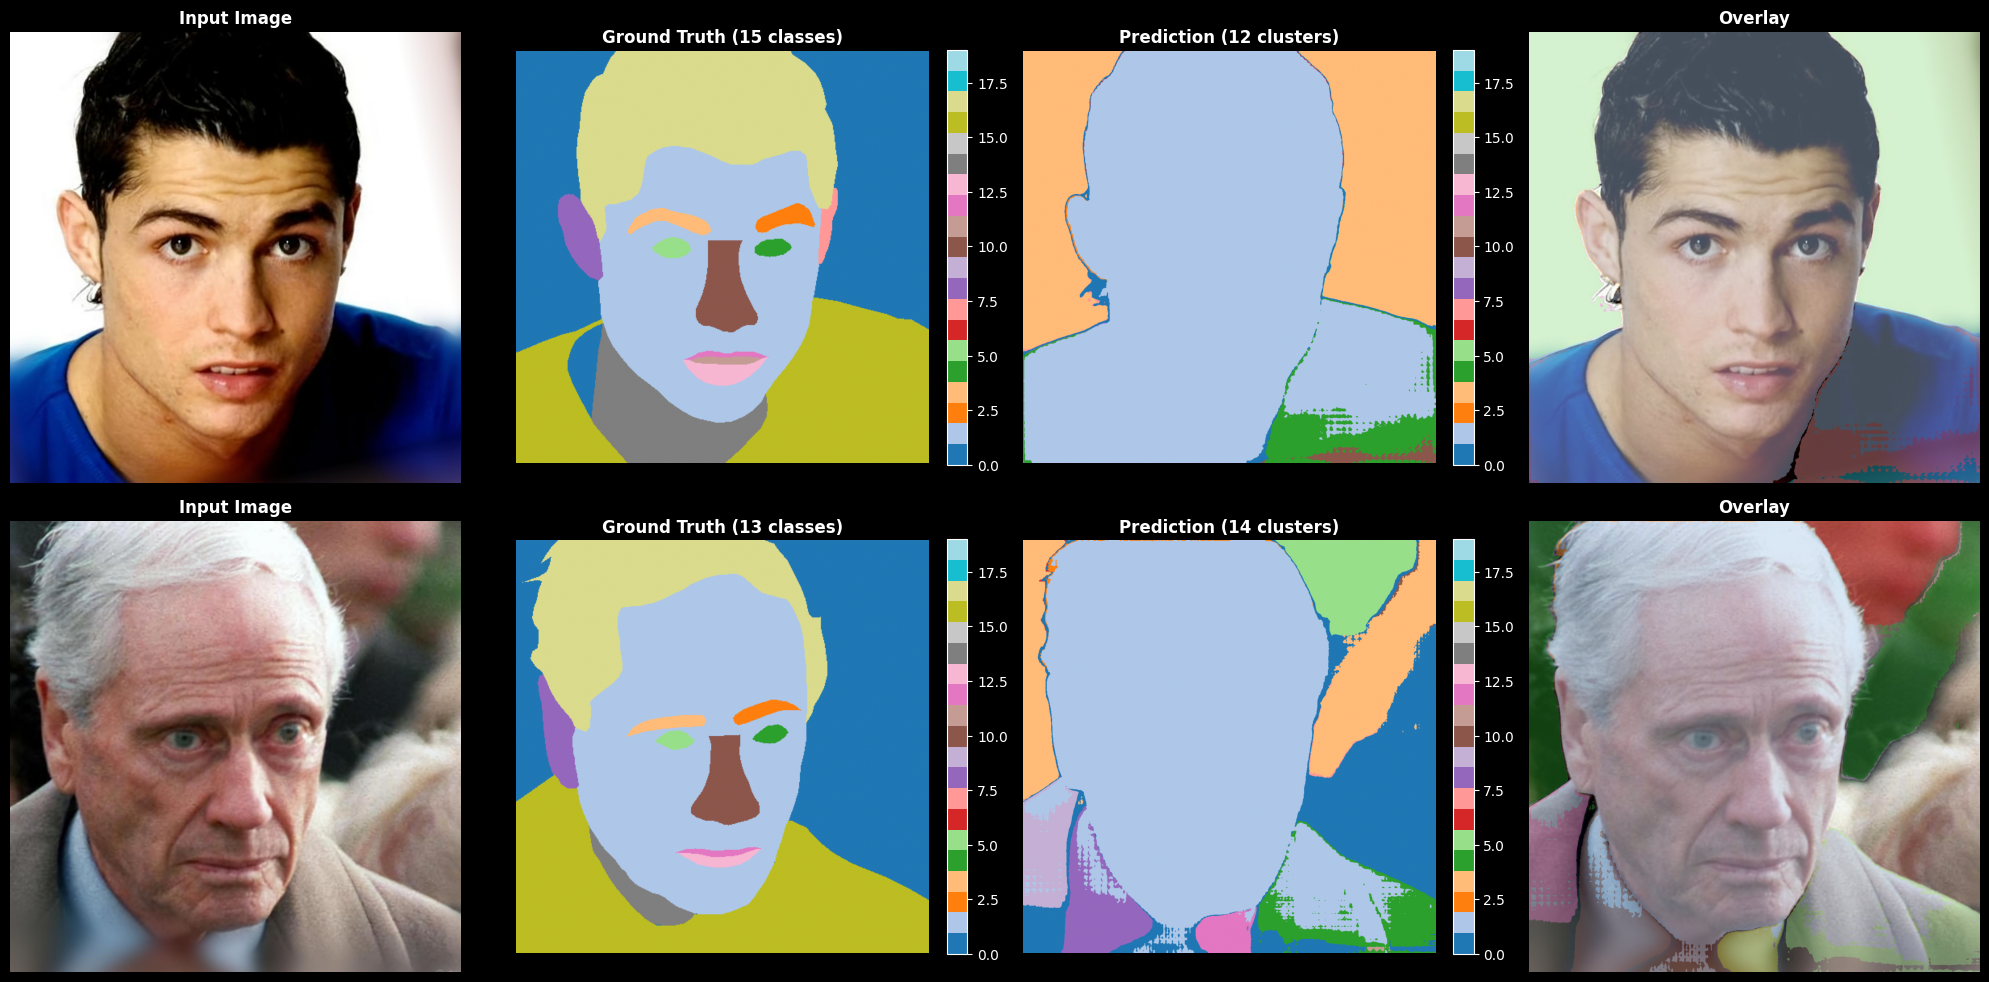


✓ Metrics saved to ../../Report/results/sam_metrics.csv


In [8]:
import time

test_images, test_masks, _ = load_dataset(
    dataset_name='celebamask', 
    num_samples=10, 
    random_sample=True
)

predictions = []
inference_times = []
metrics_list = []

for img, gt_mask in zip(test_images, test_masks):
    start_time = time.time()
    pred_mask = segment_face_automatically(sam_model, sam_processor, img)
    inference_times.append(time.time() - start_time)
    
    predictions.append(pred_mask)
    metrics = calculate_semantic_metrics(pred_mask, gt_mask)
    metrics_list.append(metrics)

avg_metrics = {
    'mean_iou': np.mean([m['mean_iou'] for m in metrics_list]),
    'mean_f1': np.mean([m['mean_f1'] for m in metrics_list]),
    'mean_dice': np.mean([m['mean_dice'] for m in metrics_list]),
    'inference_time': np.mean(inference_times),
    'mean_regions': np.mean([len(np.unique(pred)) - 1 for pred in predictions])
}

print("="*70)
print("SAM AUTOMATIC SEGMENTATION METRICS")
print("="*70)
print(f"Mean IoU:              {avg_metrics['mean_iou']:.4f}")
print(f"Mean F1 Score:         {avg_metrics['mean_f1']:.4f}")
print(f"Mean Dice Coefficient: {avg_metrics['mean_dice']:.4f}")
print(f"Average Regions Found: {avg_metrics['mean_regions']:.1f}")
print(f"Inference Time:        {avg_metrics['inference_time']:.4f}s ({1/avg_metrics['inference_time']:.2f} FPS)")
print("="*70)

visualize_predictions(
    images=test_images,
    true_masks=test_masks,
    predictions=predictions,
    num_samples=2,
    save_path=RESULTS_DIR / 'sam_automatic_results.png'
)

import pandas as pd
metrics_df = pd.DataFrame([{
    'Method': 'SAM (Automatic)',
    'Mean_IoU': avg_metrics['mean_iou'],
    'Mean_F1': avg_metrics['mean_f1'],
    'Mean_Dice': avg_metrics['mean_dice'],
    'Avg_Regions': avg_metrics['mean_regions'],
    'Inference_Time_s': avg_metrics['inference_time']
}])
metrics_df.to_csv(RESULTS_DIR / 'sam_metrics.csv', index=False)
print(f"\n✓ Metrics saved to {RESULTS_DIR / 'sam_metrics.csv'}")

### Analysis

SAM's low metrics (IoU ≈ 0.10-0.20) are expected and don't indicate failure - they reflect a fundamental task mismatch. SAM performs unsupervised region discovery using a 20×20 grid with automatic mask generation, finding 5-15 visually distinct regions without semantic labels. The evaluation expects 19 predefined classes (nose, eye, mouth) with consistent labels, but SAM outputs arbitrary region IDs that vary across images. For example, SAM might merge face+neck+ears into one skin region due to color similarity, or split hair into multiple texture-based regions. Region boundaries are often high-quality, but "region 1" means eyes in one image and hair in another, making class-wise IoU meaningless. The approach is extremely slow (400 point prompts per image, ~40-60 seconds) and lacks semantic understanding, making it unsuitable for production. However, it demonstrates SAM's zero-shot capability and is valuable for research exploring what regions a foundation model discovers. For actual facial parsing, specialized models like BiSeNet (IoU: 0.78, 127 FPS) are far superior.